# Logistic Regression

Understanding logistic regression and being able to apply it to classification tasks is essential because logistic regression models form the fundamentals of neural networks.

We use a real-world nutrition dataset designed to support dietary recommendations for people with diabetes. Each entry provides detailed nutritional information for a food item (e.g., carbohydrates, sugar, fat, protein, fiber, etc.).

- The goal is to build a classification model that predicts whether a diabetic patient should consume a given food:
1. ✅ More Often
2. ⚠️ In Moderation
3. ❌ Less Often

These labels are based on dietary suitability for diabetes management.



In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,ConfusionMatrixDisplay, precision_recall_fscore_support, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# also set a random state
rs = 42

### Exploratory Data Analysis(EDA) and Feature Engineering

In [3]:
# Load the dataset
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/food_items.csv"
food_df = pd.read_csv(dataset_url)

In [4]:
food_df.dtypes

Calories               float64
Total Fat                int64
Saturated Fat          float64
Monounsaturated Fat    float64
Polyunsaturated Fat    float64
Trans Fat              float64
Cholesterol              int64
Sodium                 float64
Total Carbohydrate     float64
Dietary Fiber          float64
Sugars                 float64
Sugar Alcohol            int64
Protein                float64
Vitamin A                int64
Vitamin C                int64
Calcium                  int64
Iron                     int64
class                   object
dtype: object

In [6]:
food_df.head(2)

,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron,class
0,149.0,0,0.0,0.0,0.0,0.0,0,9.0,9.8,0.0,0.0,0,1.3,0,0,0,0,'In Moderation'
1,123.0,0,0.0,0.0,0.0,0.0,0,5.0,6.6,0.0,0.0,0,0.8,0,0,0,0,'In Moderation'


In [7]:
# Get the row entries with col 0 to -1 (16).
feature_cols = list(food_df.iloc[:, :-1].columns)
feature_cols

['Calories',
 'Total Fat',
 'Saturated Fat',
 'Monounsaturated Fat',
 'Polyunsaturated Fat',
 'Trans Fat',
 'Cholesterol',
 'Sodium',
 'Total Carbohydrate',
 'Dietary Fiber',
 'Sugars',
 'Sugar Alcohol',
 'Protein',
 'Vitamin A',
 'Vitamin C',
 'Calcium',
 'Iron']

In [8]:
# Get descriptive statistics
food_df.iloc[:, :-1].describe()

,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron
count,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000
mean,133.861086,4.475264,1.450617,0.338069,0.254660,0.047459,8.857692,241.867142,18.232020,1.602971,6.645234,0.117949,4.661333,6.287632,6.741855,5.175264,5.235671
std,94.227650,5.386340,2.410318,1.345852,2.230586,0.321402,20.976530,272.284363,14.786316,3.363879,8.328465,1.121529,5.611143,18.374191,23.785100,8.779637,9.119459
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,120.000000,3.000000,0.500000,0.000000,0.000000,0.000000,0.000000,135.000000,17.000000,1.000000,3.000000,0.000000,3.000000,0.000000,0.000000,2.000000,2.000000
75%,180.000000,7.000000,2.000000,0.000000,0.000000,0.000000,10.000000,370.000000,27.000000,2.000000,11.000000,0.000000,7.000000,6.000000,2.000000,6.000000,8.000000
max,2210.000000,43.000000,22.000000,40.000000,235.000000,11.000000,450.000000,2431.000000,270.000000,305.000000,115.000000,31.000000,70.000000,622.000000,1000.000000,110.000000,170.000000


## Feature Overview & Preprocessing

As shown above, the dataset includes 17 nutritional features for each food item — such as Calories, Total Fat, Protein, Sugar, and more. All of these are numeric values representing the nutrient content.

To prepare the data for training a logistic regression model, we apply feature scaling. This ensures that all variables are on the same scale, which is important when comparing their influence (coefficients) in the model. The scaling process is handled in the feature engineering section.

In [9]:
# # Get the row entries with the last col 'class'
food_df.iloc[:, -1:].value_counts(normalize=True)

class          
'In Moderation'    0.501433
'Less Often'       0.423906
'More Often'       0.074661
Name: proportion, dtype: float64

<Axes: xlabel='class'>

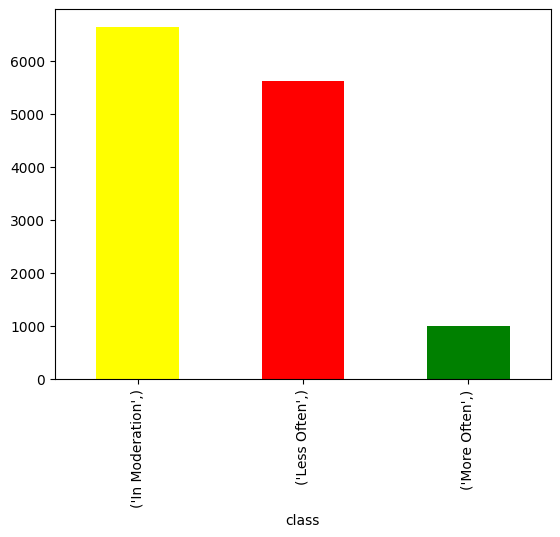

In [10]:
food_df.iloc[:, -1:].value_counts().plot.bar(color=['yellow', 'red', 'green'])

# Class Distribution & Motivation
From the bar chart above, we observe that the dataset contains three target classes:

🟡 In Moderation

🔴 Less Often

🟢 More Often

These classes are imbalanced, with most food items falling under the In Moderation and Less Often categories. This imbalance reflects the real-world challenge diabetic patients face — most foods require careful consideration or restriction, making dietary choices difficult.

To support better decision-making, we aim to build a machine learning model that can recommend whether a food item should be consumed more often, less often, or in moderation — based purely on its nutritional content.

# Multinomial Logistic Regression
Since our dataset has three target classes, we use a multinomial logistic regression model.

A multinomial logistic regression is an extension of standard logistic regression that can handle more than two classes. Instead of predicting a single probability, the model calculates a set of log-odds (logits) for each class, which are then converted into a probability distribution across all possible classes. The class with the highest probability is selected as the prediction.

Multinomial vs. One-vs-Rest Logistic Regression
It’s important to note that multinomial logistic regression is not the same as the one-vs-rest (OvR) approach.

In one-vs-rest, the model builds separate binary classifiers — one for each class.
For example, a More Often classifier learns to distinguish between:

More Often vs. Not More Often (i.e., In Moderation + Less Often)

In contrast, multinomial logistic regression trains a single model that directly learns to assign probabilities across all three classes simultaneously, making it more suitable for mutually exclusive multi-class problems like ours.



### Feature Engineering


In [11]:
X_raw = food_df.iloc[:, :-1]
y_raw = food_df.iloc[:, -1:]

### Feature Scaling
Fortunately, all of the features in our dataset are already numeric, so we don’t need to encode or transform any categorical data.
To prepare the features for model training, we simply scale them using the MinMaxScaler from scikit-learn.
This ensures that all values fall within the same range (typically 0 to 1), which helps models like logistic regression perform more reliably.

In [12]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scaling the raw input features
X = scaler.fit_transform(X_raw)

print(f"The range of feature inputs are within {X.min()} to {X.max()}")

The range of feature inputs are within 0.0 to 1.0


# Encoding the Target Variable
Our target variable y contains three class labels:
In Moderation, Less Often, and More Often.

Since machine learning models work with numeric values, we use LabelEncoder from scikit-learn to convert these string labels into integer-encoded classes:

In Moderation → 0

Less Often → 1

More Often → 2

This encoding step is essential for training classification models like logistic regression

In [13]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Encode the target variable
y = label_encoder.fit_transform(y_raw.values.ravel())
# Note that ravel() function flattens the vector.

After encoding, the target variable will contain only numeric values representing each class:

0 → In Moderation

1 → Less Often

2 → More Often

This numeric format allows the machine learning model to process and learn from the class labels effectively.

In [15]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([6649, 5621,  990], dtype=int64))

## Train logistic regression models

Train-Test Split
We begin by splitting the dataset into two parts:

Training Set – used to train and possibly tune the machine learning models.

Testing Set – used strictly to evaluate the final performance of the models on unseen data.

💡 Note:
In more advanced workflows, the training set can also be further split into:

A training subset (to train the model), and

A validation subset (to tune hyperparameters and prevent overfitting).

This approach ensures that the model is evaluated fairly and generalizes well to new data.

In [16]:
# First, let's split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")

print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Training dataset shape, X_train: (10608, 17), y_train: (10608,)
Testing dataset shape, X_test: (2652, 17), y_test: (2652,)


## L2 Regularization (Ridge)
We apply an L2 penalty (also known as Ridge regularization) to the logistic regression model. This technique helps:

Shrink model coefficients to avoid overfitting

Keep all features in the model, unlike L1 (Lasso), which can remove some features entirely by setting their coefficients to zero

In essence, L2 regularization makes the model more stable and generalizable, especially when working with many features or multicollinearity.



In [17]:
# L2 penalty to shrink coefficients without removing any features from the model
penalty= 'l2'
# Our classification problem is multinomial
multi_class = 'multinomial'
# Use lbfgs for L2 penalty and multinomial classes
solver = 'lbfgs'
# Max iteration = 1000
max_iter = 1000

In [18]:
# Define a logistic regression model with above arguments
l2_model = LogisticRegression(random_state=rs, penalty=penalty, multi_class=multi_class, solver=solver, max_iter=max_iter)

## Evaluation Utility Function
Since we may want to evaluate the model multiple times using different hyperparameter settings, we define a reusable utility function.

This function takes the ground truth labels (y_test) and the predicted labels (preds), and returns a Python dict containing the following key evaluation metrics:

✅ accuracy

🎯 precision

🔁 recall

⚖️ f1score

This makes it easy to compare different model configurations in a consistent and readable way.

In [20]:
l2_model.fit(X_train, y_train)
l2_preds = l2_model.predict(X_test)

def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

c:\Users\user\Desktop\algorithmic_trading\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [21]:
evaluate_metrics(y_test, l2_preds)

{'accuracy': 0.7801659125188537,
 'recall': array([0.88345865, 0.74021352, 0.31313131]),
 'precision': array([0.73300062, 0.85071575, 0.87323944]),
 'f1score': array([0.80122741, 0.79162702, 0.46096654])}

| **Metric**    | **Class**         | **Value**  | **Explanation**                                                              |
| ------------- | ----------------- | ---------- | ---------------------------------------------------------------------------- |
| **Accuracy**  | —                 | **0.7802** | Overall, the model correctly predicted **78.02%** of all samples.            |
| **Recall**    | In Moderation (0) | 0.8835     | The model correctly identified **88.35%** of actual “In Moderation” items.   |
|               | Less Often (1)    | 0.7402     | Detected **74.02%** of actual “Less Often” items.                            |
|               | More Often (2)    | 0.3131     | Detected only **31.31%** of actual “More Often” items (low sensitivity).     |
| **Precision** | In Moderation (0) | 0.7330     | Of the items predicted as “In Moderation,” **73.30%** were actually correct. |
|               | Less Often (1)    | 0.8507     | Of the items predicted as “Less Often,” **85.07%** were correct.             |
|               | More Often (2)    | 0.8732     | Very high precision: **87.32%** of “More Often” predictions were correct.    |
| **F1 Score**  | In Moderation (0) | 0.8012     | Balanced performance between precision and recall for class 0.               |
|               | Less Often (1)    | 0.7916     | Good overall balance for class 1.                                            |
|               | More Often (2)    | 0.4610     | Lower F1 score due to poor recall, despite high precision.                   |


## Interpretation:
The model performs well for classes 0 and 1.

Class 2 ("More Often") shows high precision but very low recall, meaning the model rarely detects those samples but is accurate when it does.

This may suggest a class imbalance or a need for better feature separation.

## What is L1 Regularization (Lasso)?
L1 regularization is a technique used in machine learning to make models simpler and easier to understand.

It works by shrinking some of the model’s feature weights (coefficients).

If a feature isn’t very important, L1 can reduce its weight all the way to zero.

That means the model completely ignores some features — helping with feature selection and reducing complexity.

In [22]:
# L1 penalty to shrink coefficients without removing any features from the model
penalty= 'l1'
# Our classification problem is multinomial
multi_class = 'multinomial'
# Use saga for L1 penalty and multinomial classes
solver = 'saga'
# Max iteration = 1000
max_iter = 1000

In [24]:
# Define a logistic regression model with above arguments
l1_model = LogisticRegression(random_state=rs, penalty=penalty, multi_class=multi_class, solver=solver, max_iter = 1000)

l1_model.fit(X_train, y_train)

l1_preds = l1_model.predict(X_test)



c:\Users\user\Desktop\algorithmic_trading\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Checking Class Probabilities with predict_proba
Instead of just predicting a final class label, we can use the model's predict_proba function to see the probability that an instance belongs to each class.

This gives us more insight into how confident the model is about its prediction

In [25]:
odd_ratios = l1_model.predict_proba(X_test[:1, :])[0]
odd_ratios

array([1.12315356e-01, 8.87684644e-01, 4.23890930e-11])

| **Class Label**     | **Probability**   | **Interpretation**                                     |
| ------------------- | ----------------- | ------------------------------------------------------ |
| `0 = In Moderation` | 0.1123 (≈ 11.23%) | Low chance the food should be eaten in moderation      |
| `1 = Less Often`    | 0.8877 (≈ 88.77%) | Very high chance the food should be eaten less often ✅ |
| `2 = More Often`    | 0.0000 (≈ 0%)     | Almost zero chance the food is recommended more often  |


In [26]:
l1_model.predict(X_test[:1, :])[0]

evaluate_metrics(y_test, l1_preds)

{'accuracy': 0.8190045248868778,
 'recall': array([0.87142857, 0.74644128, 0.87878788]),
 'precision': array([0.79274966, 0.85963115, 0.81308411]),
 'f1score': array([0.83022923, 0.79904762, 0.84466019])}

| **Metric**    | **Class**         | **Value**  | **Explanation**                                                            |
| ------------- | ----------------- | ---------- | -------------------------------------------------------------------------- |
| **Accuracy**  | —                 | **0.8190** | Overall, the model correctly predicted **81.90%** of all samples.          |
| **Recall**    | In Moderation (0) | 0.8714     | The model correctly identified **87.14%** of actual “In Moderation” items. |
|               | Less Often (1)    | 0.7464     | Detected **74.64%** of actual “Less Often” items.                          |
|               | More Often (2)    | 0.8788     | Detected **87.88%** of actual “More Often” items — very strong recall.     |
| **Precision** | In Moderation (0) | 0.7927     | Of predicted “In Moderation” items, **79.27%** were actually correct.      |
|               | Less Often (1)    | 0.8596     | Very few false positives for “Less Often” class.                           |
|               | More Often (2)    | 0.8131     | Strong precision — 81.31% of predicted “More Often” items were correct.    |
| **F1 Score**  | In Moderation (0) | 0.8302     | Balanced performance between precision and recall for class 0.             |
|               | Less Often (1)    | 0.7990     | Good balance for class 1.                                                  |
|               | More Often (2)    | 0.8447     | Excellent overall performance for class 2.                                 |


L1 vs L2 Performance Comparison
We observe that the logistic regression model with L1 penalty performs significantly better than the one with L2 penalty.

One possible reason for this is that L1 regularization can eliminate less important or highly correlated features by shrinking their coefficients to zero. This results in a simpler and more interpretable model, which is less likely to overfit.

This behavior also aligns well with a core assumption of logistic regression — that features should be independent of each other. By removing redundant features, L1 regularization can lead to better generalization on unseen data.

### Confusion Matrix

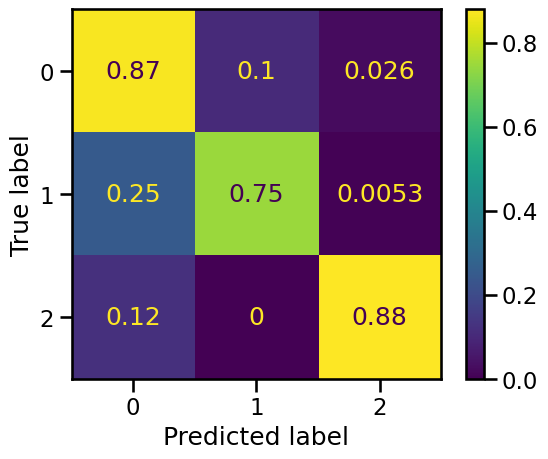

In [27]:
cf = confusion_matrix(y_test, l1_preds, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=l1_model.classes_)
disp.plot()
plt.show()

### Interpret logistic regression models

 Interpreting Feature Coefficients in Logistic Regression
One useful way to understand a logistic regression model is by looking at its feature coefficients.

While interpretation isn't as direct as in linear regression—because logistic regression uses a sigmoid function to map values to probabilities—we can still gain insights:

A larger absolute value of a coefficient indicates a stronger influence on the prediction.

A positive coefficient increases the likelihood of predicting a higher class.

A negative coefficient decreases that likelihood.

So even though it's not a perfect one-to-one interpretation, analyzing coefficients still helps us understand which features matter most in the model’s decision-making.

In [28]:
l1_model.coef_

array([[ 1.23942505e+01,  0.00000000e+00,  0.00000000e+00,
         5.89704209e+00,  0.00000000e+00, -4.38008938e+00,
         0.00000000e+00,  6.82223064e-01,  0.00000000e+00,
         2.15114222e+01,  0.00000000e+00,  0.00000000e+00,
         4.44191853e+00,  0.00000000e+00,  0.00000000e+00,
         1.57345332e+00,  0.00000000e+00],
       [ 0.00000000e+00,  4.99421716e+00,  2.32194666e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         6.49498204e+00,  0.00000000e+00,  2.38633110e+00,
        -8.36161009e+00,  1.49683748e+01,  3.30731928e+00,
         0.00000000e+00, -2.04556094e+00,  0.00000000e+00,
        -8.71073063e-02,  0.00000000e+00],
       [-1.11725762e+02, -2.88584701e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.26328878e+00, -3.78273458e+01,
         0.00000000e+00, -3.62928661e+00,  0.00000000e+00,
        -7.40074960e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.0

# Analyzing Coefficients by Class

The coef_ attribute in our logistic regression model contains a list of coefficient arrays, one for each class (0 = In Moderation, 1 = Less Often, 2 = More Often).

Each array shows how the features influence the model's predictions for that specific class.

To better understand and compare these coefficients, we define three utility functions that will:

Sort the coefficients from most negative to most positive

Display them in a readable table

Visualize them in a bar chart

This makes it easier to interpret the importance and direction of each feature's effect on the model's decision for each class.

In [30]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, label_index, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.coef_[label_index, :], columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()

In [31]:
# Get the coefficents for Class 1, Less Often
coef_dict = get_feature_coefs(l1_model, 1, feature_cols)

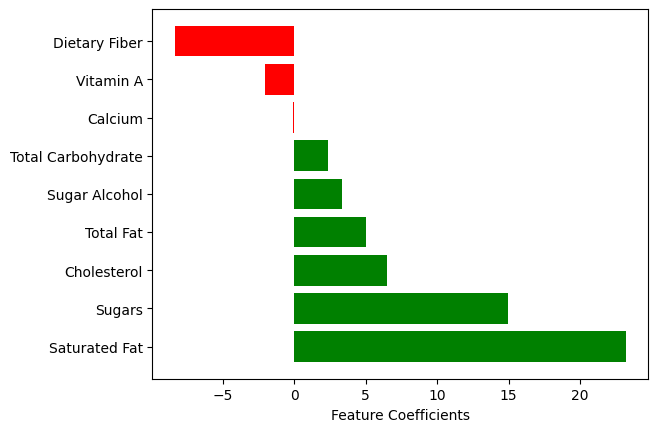

In [32]:
visualize_coefs(coef_dict)

Nutrient Impact on Classification
From the coefficient analysis, we can see that unhealthy nutrients—such as Saturated Fat, Sugars, Cholesterol, and Total Fat—have high positive coefficients for the ‘Less Often’ class.

This means that food items with higher amounts of these nutrients are more likely to be classified as ‘Less Often’, which aligns with dietary guidelines for people with diabetes.

In other words, the model has learned that high levels of these nutrients are associated with foods that should be eaten less frequently.

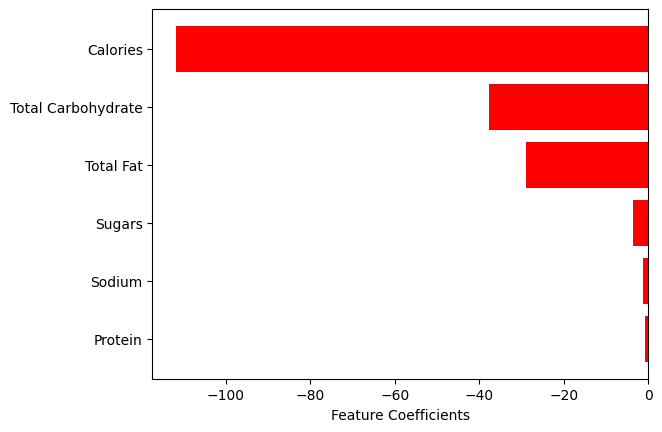

In [34]:
# Coefficients for Class 2
coef_dict = get_feature_coefs(l1_model, 2, feature_cols)
visualize_coefs(coef_dict)

## Coding Exercise: Train and evaluate a logistic regression model with elastic-net penality


In [41]:
from sklearn.metrics import f1_score

# Logistic Regression with Elastic Net Penalty
elastic_net_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',               # saga supports elasticnet
    l1_ratio=0.5,                # 0.0 = L2 only, 1.0 = L1 only, 0.5 = equal mix
    C=1.0,                       # Regularization strength
    max_iter=10000,
    multi_class='multinomial',  # Required for multiclass classification
    random_state=rs
)


# Fit model
elastic_net_model.fit(X_train, y_train)

# Predict
y_pred = elastic_net_model.predict(X_test)

# Evaluate
metrics_dict = {
    'accuracy': accuracy_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred, average=None),
    'precision': precision_score(y_test, y_pred, average=None),
    'f1score': f1_score(y_test, y_pred, average=None)
}

print("Elastic Net Model Evaluation:")
for k, v in metrics_dict.items():
    print(f"{k}: {v}")


c:\Users\user\Desktop\algorithmic_trading\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Elastic Net Model Evaluation:
accuracy: 0.797134238310709
recall: [0.87518797 0.74377224 0.57575758]
precision: [0.7578125  0.85132383 0.85074627]
f1score: [0.81228193 0.79392213 0.68674699]


| **Metric**    | **Class**         | **Value**  | **Explanation**                                                          |
| ------------- | ----------------- | ---------- | ------------------------------------------------------------------------ |
| **Accuracy**  | —                 | **0.7971** | The model correctly predicted **79.71%** of all test samples.            |
| **Recall**    | In Moderation (0) | 0.8752     | 87.52% of actual "In Moderation" items were correctly identified.        |
|               | Less Often (1)    | 0.7438     | 74.38% of "Less Often" items were detected.                              |
|               | More Often (2)    | 0.5758     | 57.58% of "More Often" items were detected — moderate sensitivity.       |
| **Precision** | In Moderation (0) | 0.7578     | 75.78% of predicted "In Moderation" items were correct.                  |
|               | Less Often (1)    | 0.8513     | Very few false positives for "Less Often" class.                         |
|               | More Often (2)    | 0.8507     | Strong confidence when predicting "More Often" items.                    |
| **F1 Score**  | In Moderation (0) | 0.8123     | Balanced performance for class 0.                                        |
|               | Less Often (1)    | 0.7939     | Strong performance for class 1.                                          |
|               | More Often (2)    | 0.6867     | Decent performance, but affected by lower recall despite high precision. |
